This notebook will get a take a protein family of choice from UniProt, download the sequences with annotations such as domains, PDB codes and taxonomy and then cluster by similarity. 

The sequence space will be plotted and the most representative sequences will be taken from across the sequence space 

Finally the selected sequences will be analysed for solubility and expressebility in e coli 

Eventually this will be combined with automated analysis of the proteins in the lab to train a reinforcement learning network 

First you will need to go to uniprot, search for the interpro or pfam ID you are interested in. We will download 2 files, a Fasta file and a TSV file
for the fasta file just download the default option. for TSV follow below.
Select download, format: TSV and select the annotations you are interested in. I generally add taxnomic lineage, PDB, and domain [FT], ensure you also. Then generate URL for API. 

In [1]:
#get sequence data using uniprot api 
import requests

url = 'https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Clineage%2Cxref_pdb%2Cft_domain&format=tsv&query=%28IPR001223%29+AND+%28reviewed%3Atrue%29' #enter your URL here
sequences = requests.get(url).text

Instead of using the API we can just download the TSV and move it to the directory you are running this notebook from. Then we will use mmseqs to clean the data create an all by all comparison, you will need to install mmseqs2 first. https://github.com/soedinglab/mmseqs2/wiki

In [2]:
# remove sequences with greater than 0.8 sequence identity
!mmseqs easy-cluster input.fasta clusterRes tmp --min-seq-id 0.8 #clusters sequences with 80% similarity

easy-cluster input.fasta clusterRes tmp --min-seq-id 0.8 

MMseqs Version:                     	15-6f452
Substitution matrix                 	aa:blosum62.out,nucl:nucleotide.out
Seed substitution matrix            	aa:VTML80.out,nucl:nucleotide.out
Sensitivity                         	4
k-mer length                        	0
Target search mode                  	0
k-score                             	seq:2147483647,prof:2147483647
Alphabet size                       	aa:21,nucl:5
Max sequence length                 	65535
Max results per query               	20
Split database                      	0
Split mode                          	2
Split memory limit                  	0
Coverage threshold                  	0.8
Coverage mode                       	0
Compositional bias                  	1
Compositional bias                  	1
Diagonal scoring                    	true
Exact k-mer matching                	0
Mask residues                       	1
Mask residues probability           	0

After cleaning the dataset we need to do an all by all comparison to cluster the sequences by similarity 

In [3]:
# perform all by all search on cleaned sequences
!mmseqs easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

all_by_all.tsv exists and will be overwritten
easy-search clusterRes_rep_seq.fasta clusterRes_rep_seq.fasta all_by_all.tsv /tmp --threads 8 

MMseqs Version:                        	15-6f452
Substitution matrix                    	aa:blosum62.out,nucl:nucleotide.out
Add backtrace                          	false
Alignment mode                         	3
Alignment mode                         	0
Allow wrapped scoring                  	false
E-value threshold                      	0.001
Seq. id. threshold                     	0
Min alignment length                   	0
Seq. id. mode                          	0
Alternative alignments                 	0
Coverage threshold                     	0
Coverage mode                          	0
Max sequence length                    	65535
Compositional bias                     	1
Compositional bias                     	1
Max reject                             	2147483647
Max accept                             	2147483647
Include identical seq. id. 

Now we will use John's Cluster tools package to analyse the results of the all by all search

In [5]:
#first import the modules we need

from ClusterTools.cluster_stream import cluster_stream
from ClusterTools.cluster_progression import cluster_progression
#from ClusterTools.circle_plot import PlotCirclesBox2D
from ClusterTools.cluster_size_table import MakeTable
from ClusterTools.cluster_consensus import ParseClusters
import sys
sys.path.append("./ClusterTools/")  # replace with the actual path
import pandas as pd

The code below analyses how the cluster sizes vary by bitscore cutoff, other scoring metrics can be used by changing the score setting to a different column in the all_by_all.tsv file

In [6]:
cluster_stream('all_by_all.tsv',cutoffs=[100,200,300,400,500,600,700], score = 3, directory='cluster_stream_res')

---cutoff: 100
2 clusters with 126 sequences
5 single nodes added
0 unconnected nodes added
---cutoff: 200
4 clusters with 122 sequences
9 single nodes added
0 unconnected nodes added
---cutoff: 300
3 clusters with 116 sequences
15 single nodes added
0 unconnected nodes added
---cutoff: 400
4 clusters with 82 sequences
49 single nodes added
0 unconnected nodes added
---cutoff: 500
9 clusters with 35 sequences
96 single nodes added
0 unconnected nodes added
---cutoff: 600
5 clusters with 19 sequences
112 single nodes added
0 unconnected nodes added
---cutoff: 700
5 clusters with 16 sequences
115 single nodes added
0 unconnected nodes added
5373 
0.04s



['cluster_400.csv', 'cluster_600.csv', 'cluster_200.csv', 'cluster_700.csv', 'cluster_500.csv', 'cluster_100.csv', 'cluster_300.csv']


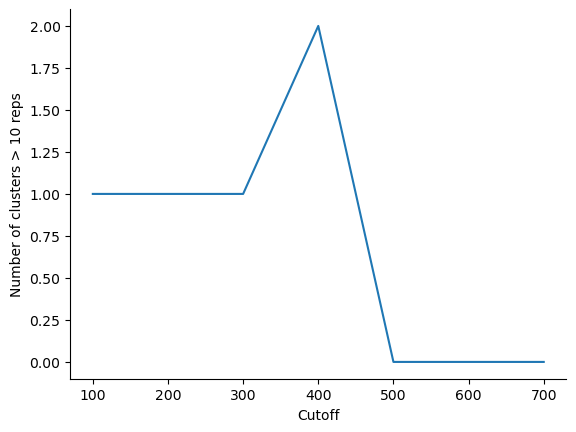

In [7]:
cluster_progression('cluster_stream_res', filter = 10)

the next function creates a table with the cluster IDs and the numbers of members. list files containing uniprot IDs of interest can be added as additional arguments to locate which cluster these proteins are in.

In [8]:
clusters = MakeTable('cluster_stream_res/cluster_400.csv', )
print(clusters)
clusters.to_csv('cluster_size_table.csv', index=False)

    cluster  rep_count
0         0         66
1         1         11
2         2          3
3         3          2
40       40          1
30       30          1
31       31          1
32       32          1
33       33          1
34       34          1
35       35          1
36       36          1
37       37          1
38       38          1
39       39          1
41       41          1
28       28          1
42       42          1
43       43          1
44       44          1
45       45          1
46       46          1
47       47          1
48       48          1
49       49          1
50       50          1
51       51          1
29       29          1
26       26          1
27       27          1
25       25          1
4         4          1
5         5          1
6         6          1
7         7          1
8         8          1
9         9          1
10       10          1
11       11          1
12       12          1
13       13          1
14       14          1
15       15

The next function, ParseClusters will create a zip file containing an Hmm and an alginment file for each cluster with the most representative sequence at the top

In [9]:
def clusters_to_string_list(clusters):
    # Filter clusters with at least 2 members
    filtered_clusters = clusters[clusters['rep_count'] >= 2]  # Assuming 'rep_count' contains the member count
    return filtered_clusters['cluster'].astype(str).tolist()

cluster_list = clusters_to_string_list(clusters)
print(cluster_list)


['0', '1', '2', '3']


In [10]:
ParseClusters(cluster_file='cluster_stream_res/cluster_400.csv', fasta_file= 'clusterRes_all_seqs.fasta',target_clusters=cluster_list,zip_path='consensus_cutoff500.zip')
# unzip the consensus to seperate folder
#import zipfile
#with zipfile.ZipFile('consensus_cutoff500.zip', 'r') as zip_ref:
    #zip_ref.extractall('consensus_cutoff500')

Alignment input open failed.
   couldn't guess alphabet (maybe try --dna/--rna/--amino if available)
   while reading file /var/folders/59/bmyszbkd2r72dz4klgd4xbrh0000gn/T/tmpnf3midpu/cluster_1.aln
   while parsing for aligned FASTA format
Alignment input open failed.
Alignment input open failed.
   couldn't guess alphabet (maybe try --dna/--rna/--amino if available)
   couldn't guess alphabet (maybe try --dna/--rna/--amino if available)
   while reading file /var/folders/59/bmyszbkd2r72dz4klgd4xbrh0000gn/T/tmpch0au0d8/cluster_2.aln
   while reading file /var/folders/59/bmyszbkd2r72dz4klgd4xbrh0000gn/T/tmpk0ysx61a/cluster_0.aln
   while parsing for aligned FASTA format
   while parsing for aligned FASTA format
Alignment input open failed.
   couldn't guess alphabet (maybe try --dna/--rna/--amino if available)
   while reading file /var/folders/59/bmyszbkd2r72dz4klgd4xbrh0000gn/T/tmppsfiv4bj/cluster_3.aln
   while parsing for aligned FASTA format

Error: 
Error: 
Error: File existence/p

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/59/bmyszbkd2r72dz4klgd4xbrh0000gn/T/tmpnf3midpu/cluster_1.hits'

In [58]:
# Example: Verify that cluster 0 contains members
cluster_0_members = clusters[clusters['cluster'] == 0]
print(cluster_0_members)  # Check if there are members

   cluster  rep_count
0        0         66
